In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

# Load the uploaded CSV file
file_path = "../results/base_results(1).csv"
df_raw = pd.read_csv(file_path)


# Update the function to handle alias model names
def load_model_data(df: pd.DataFrame, model_type: str) -> pd.DataFrame:
    # Normalize model type
    model_aliases = {
        "svm": "svm",
        "rf": "rf",
        "random_forest": "rf",
        "lgbm": "lgbm",
        "lightgbm": "lgbm"
    }
    base_type = model_aliases.get(model_type)
    if base_type is None:
        raise ValueError("Unknown model type")

    # Filter relevant rows
    df_model = df[df["Unnamed: 0"].str.startswith(model_type)].copy()

    # Prefix logic
    if base_type == "svm" or base_type == "rf":
        param_prefix = "static_"
    elif base_type == "lgbm":
        param_prefix = "final_"

    # Extract only relevant parameter columns
    param_cols = [col for col in df_model.columns if col.startswith(param_prefix)]
    other_cols = [col for col in df_model.columns if not col.startswith("static_") and not col.startswith("final_")]

    # Fill missing parameter values with values from the first row
    df_model[param_cols] = df_model[param_cols].ffill()

    # Return cleaned dataframe
    return df_model[other_cols + param_cols]

# Reload with updated function
df_rf = load_model_data(df_raw, "random_forest")
df_lgbm = load_model_data(df_raw, "lightgbm")


# Test the function for SVM
df_svm = load_model_data(df_raw, "svm")



C:\Users\Mikołaj\AppData\Local\Temp\ipykernel_11712\169683357.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model[param_cols] = df_model[param_cols].ffill()
C:\Users\Mikołaj\AppData\Local\Temp\ipykernel_11712\169683357.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model[param_cols] = df_model[param_cols].ffill()
C:\Users\Mikołaj\AppData\Local\Temp\ipykernel_11712\169683357.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=F

In [2]:
def plot_metric_bars_by_param(df: pd.DataFrame, param: str, model_prefix: str):
    """
    Final version: grouped bar plot with color-coded metrics, transparent train/test overlay,
    simplified legends placed outside plot area.
    """

    if model_prefix in ["svm", "rf", "random_forest"]:
        param_col = f"static_{param}"
    elif model_prefix in ["lgbm", "lightgbm"]:
        param_col = f"final_{param}"
    else:
        print(f"❌ Nieobsługiwany model_prefix: {model_prefix}")
        return

    if param_col not in df.columns:
        print(f"❌ Kolumna parametru '{param_col}' nie istnieje.")
        return

    df_param = df.dropna(subset=[param_col])
    if df_param.empty:
        print(f"⚠️ Wszystkie wartości parametru '{param_col}' są puste.")
        return

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    colors = {
        'accuracy': '#636EFA',   # deep blue
        'precision': '#EF553B',  # soft red
        'recall': '#00CC96',     # teal
        'f1_score': '#AB63FA',   # lavender
        'auc_roc': '#FFA15A'     # orange
    }



    melted_data = []
    for _, row in df_param.iterrows():
        param_val = row[param_col]
        for metric in metrics:
            melted_data.append({
                'param': str(param_val), 'metric': metric, 'value': row[f'train_{metric}'],
                'dataset': 'train'
            })
            melted_data.append({
                'param': str(param_val), 'metric': metric, 'value': row[f'test_{metric}'],
                'dataset': 'test'
            })

    df_plot = pd.DataFrame(melted_data)

    unique_params = df_plot['param'].unique()
    n_metrics = len(metrics)
    bar_width = 0.9
    spacing = 1.0

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, p in enumerate(unique_params):
        for j, metric in enumerate(metrics):
            base_x = i * (n_metrics + spacing)
            x = base_x + j
            df_subset = df_plot[(df_plot['param'] == p) & (df_plot['metric'] == metric)]

            for ds in ['train', 'test']:
                val = df_subset[df_subset['dataset'] == ds]['value'].values
                if val.size > 0:
                    alpha = 0.5 if ds == 'train' else 0.8
                    ax.bar(x, val[0], color=colors[metric], alpha=alpha, width=bar_width)

    # Oś X
    ax.set_xticks([(i * (n_metrics + spacing)) + (n_metrics - 1) / 2 for i in range(len(unique_params))])
    ax.set_xticklabels(unique_params)
    ax.set_xlabel(param)
    ax.set_ylabel("Metric Value")
    ax.set_title(f"Train vs Test Metrics for parameter '{param}' [{model_prefix.upper()}]")
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)  # grid behind bars
    ax.set_ylim(0.7, 1.0)

    


    # Legenda metryk (kolory)
    metric_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[m], alpha=1.0) for m in metrics]
    metric_labels = [f"{m}" for m in metrics]

    # Legenda przezroczystości: train/test
    transparency_handles = [
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.5),
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.8)
    ]
    transparency_labels = ["train", "test"]

    
    legend2 = ax.legend(transparency_handles, transparency_labels, title="Dataset", loc='lower left', bbox_to_anchor=(1, 0.80))
    legend1 = ax.legend(metric_handles, metric_labels, title="Metric", loc='upper left', bbox_to_anchor=(1, 0.7))
    ax.add_artist(legend2)

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legends on the right
    plt.show()


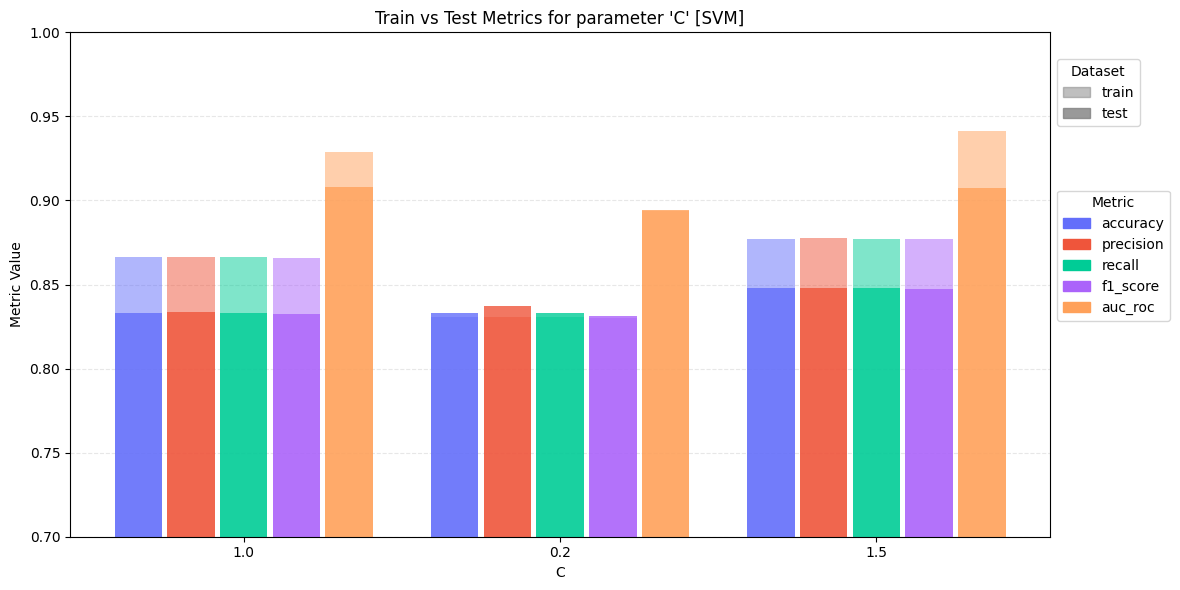

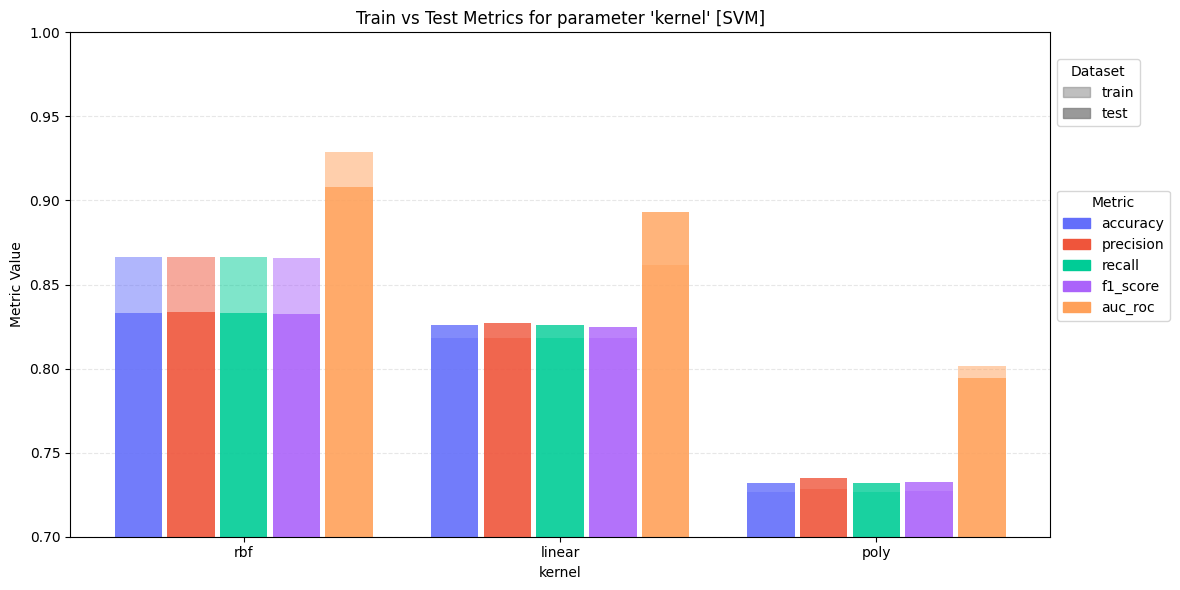

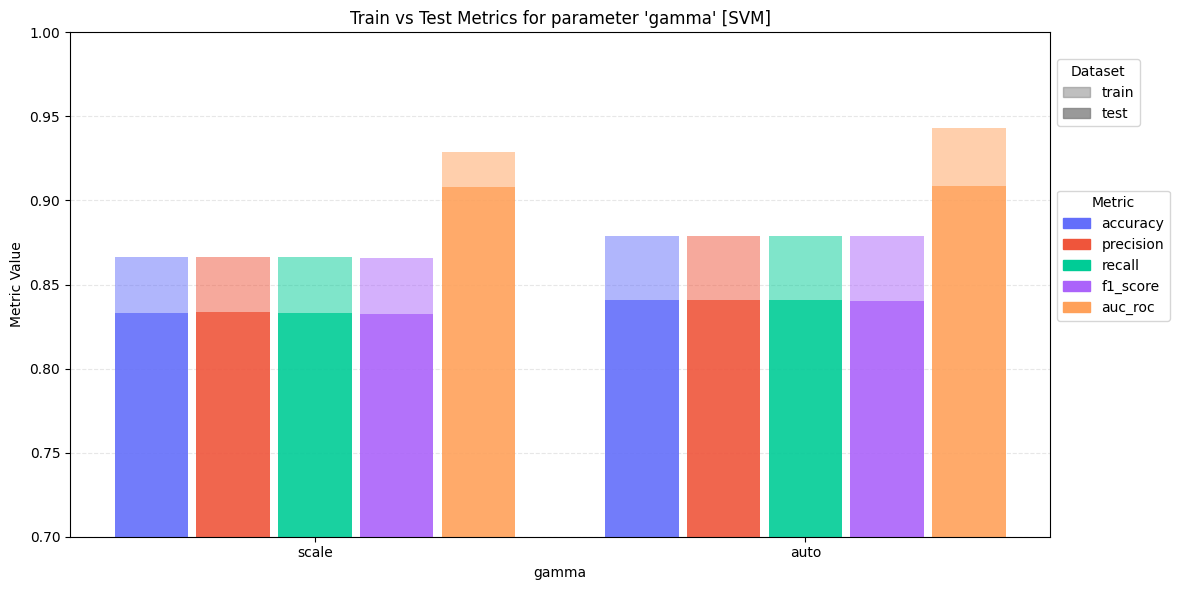

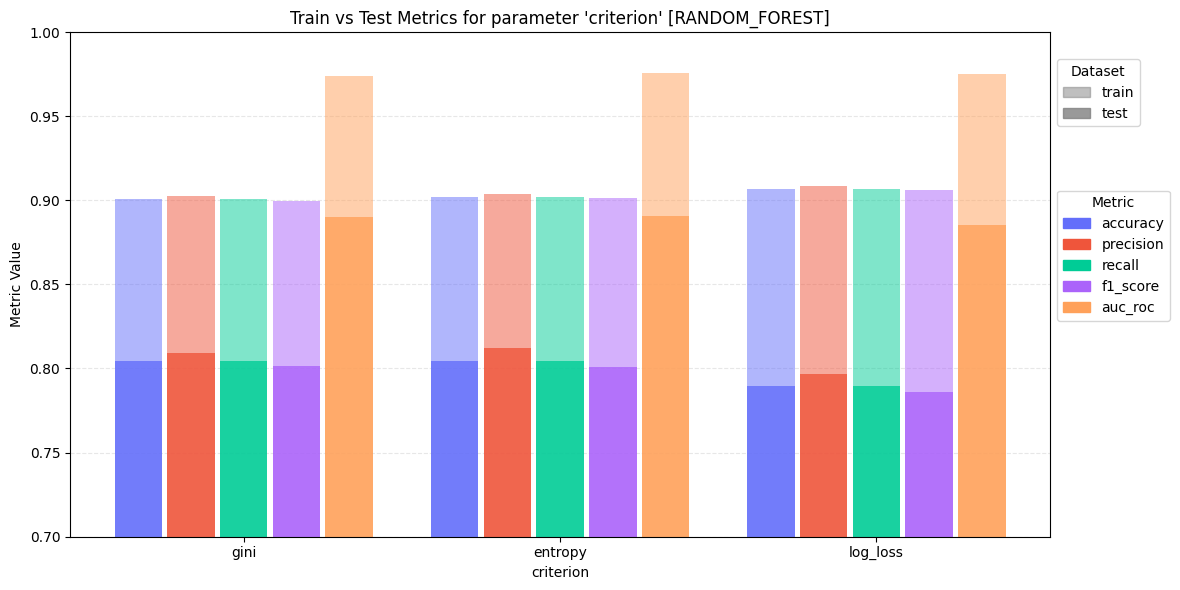

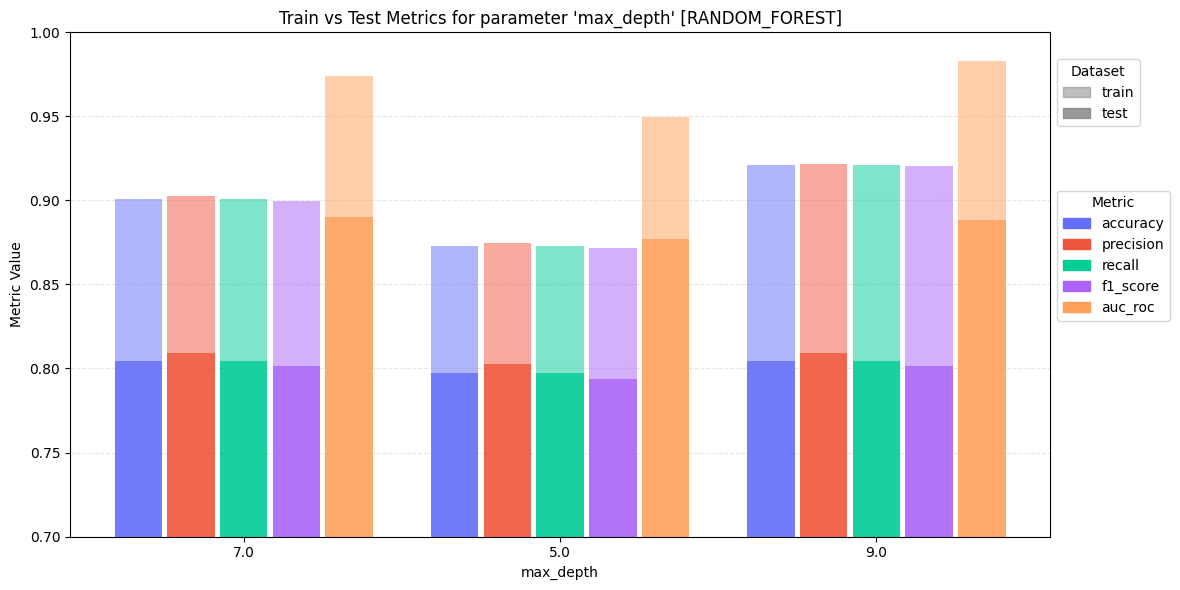

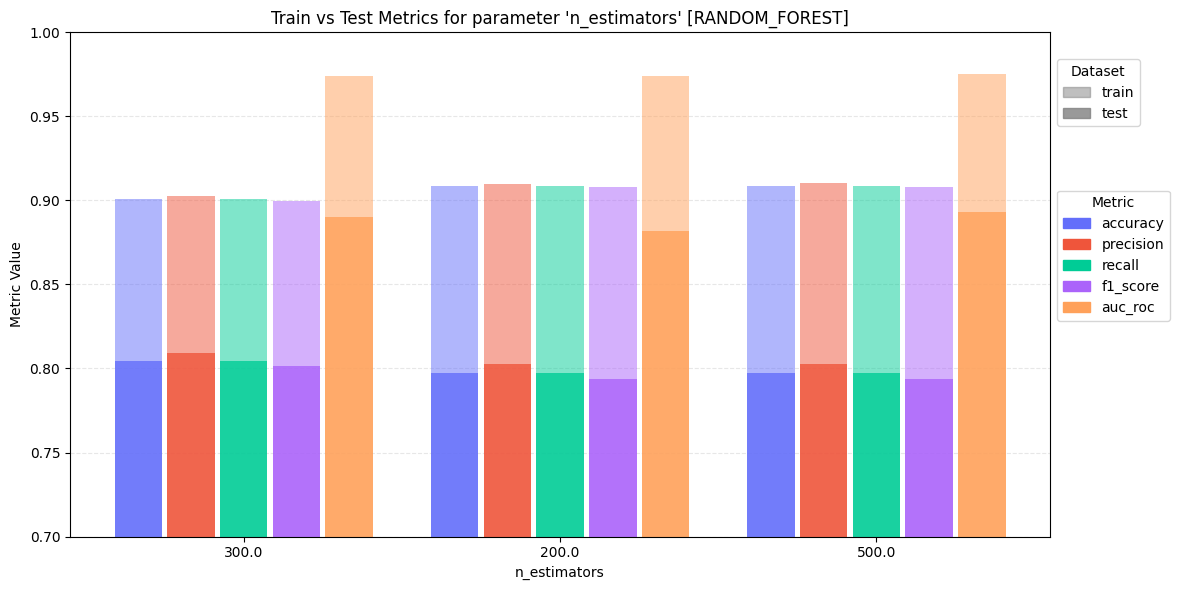

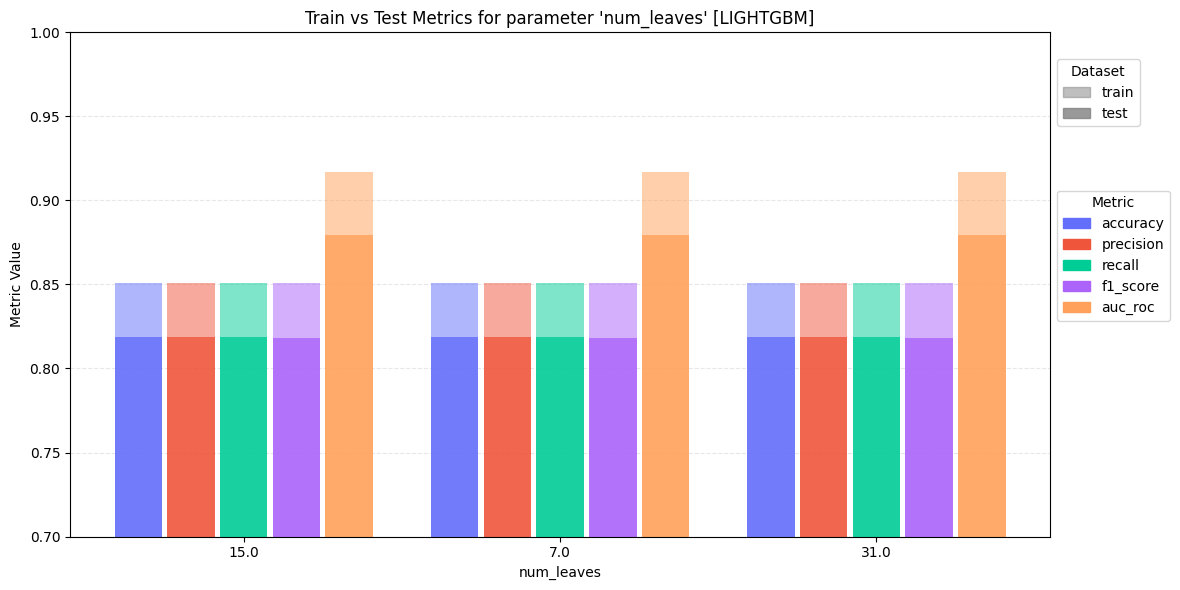

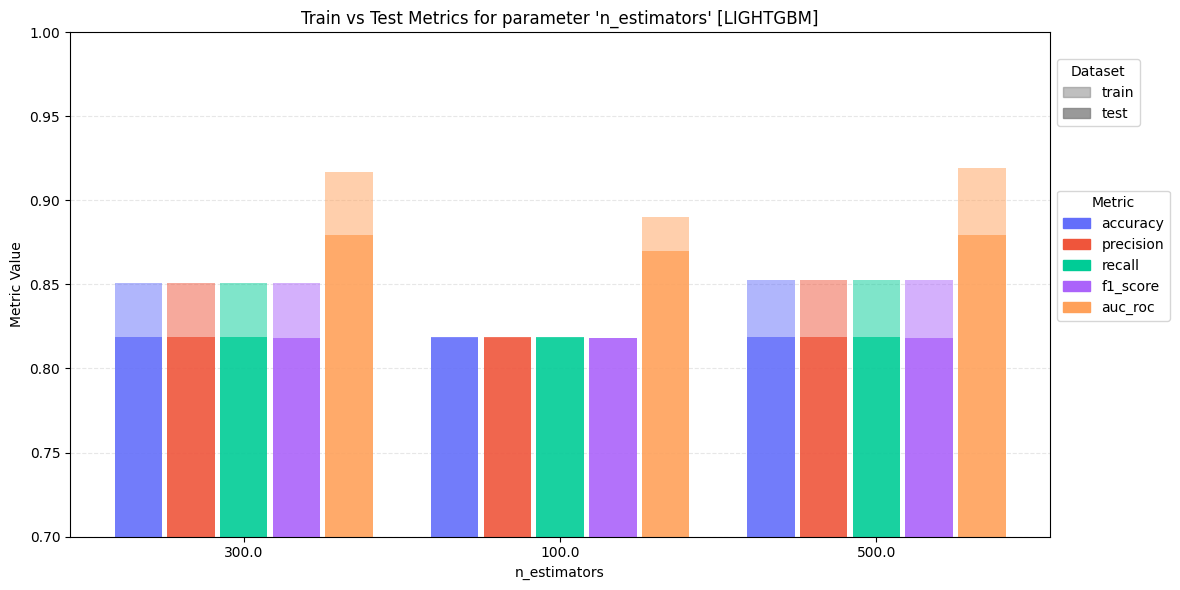

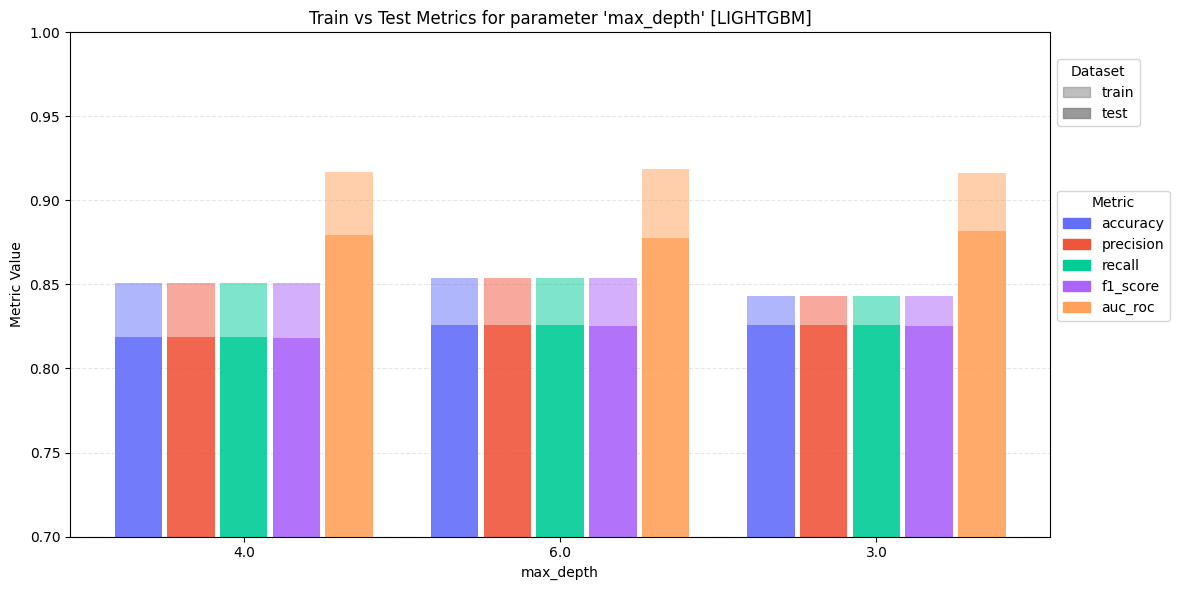

In [ ]:

plot_metric_bars_by_param(df_svm, param="C", model_prefix="svm")
plot_metric_bars_by_param(df_svm, param="kernel", model_prefix="svm")
plot_metric_bars_by_param(df_svm, param="gamma", model_prefix="svm")

plot_metric_bars_by_param(df_rf, param="criterion", model_prefix="random_forest")
plot_metric_bars_by_param(df_rf, param="max_depth", model_prefix="random_forest")
plot_metric_bars_by_param(df_rf, param="n_estimators", model_prefix="random_forest")

plot_metric_bars_by_param(df_lgbm, param="num_leaves", model_prefix="lightgbm")
plot_metric_bars_by_param(df_lgbm, param="n_estimators", model_prefix="lightgbm")
plot_metric_bars_by_param(df_lgbm, param="max_depth", model_prefix="lightgbm")


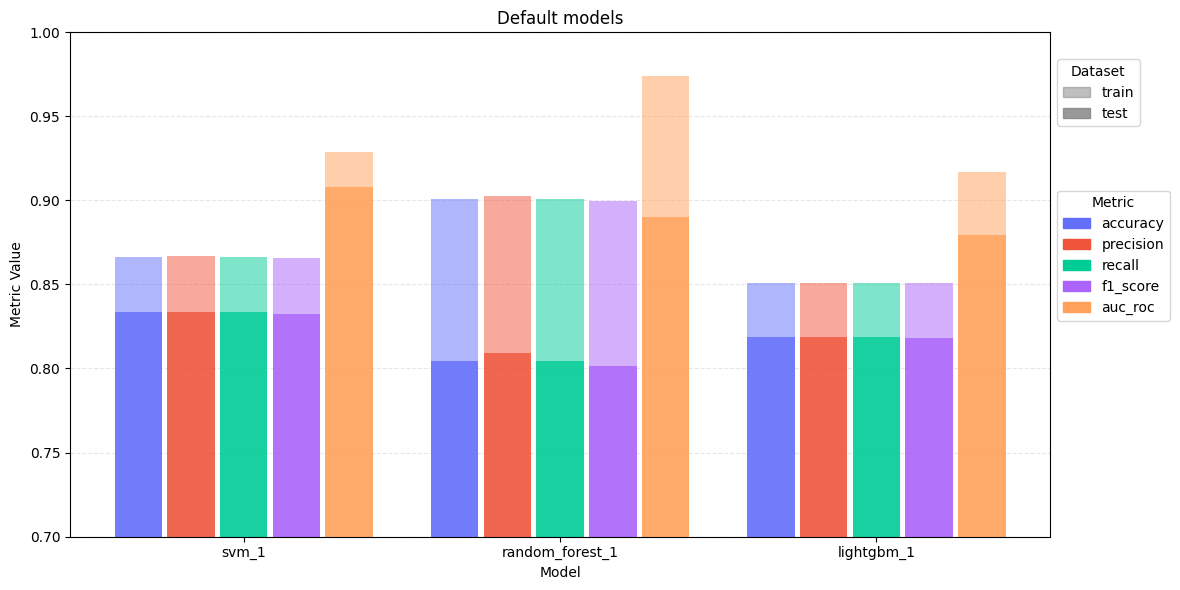

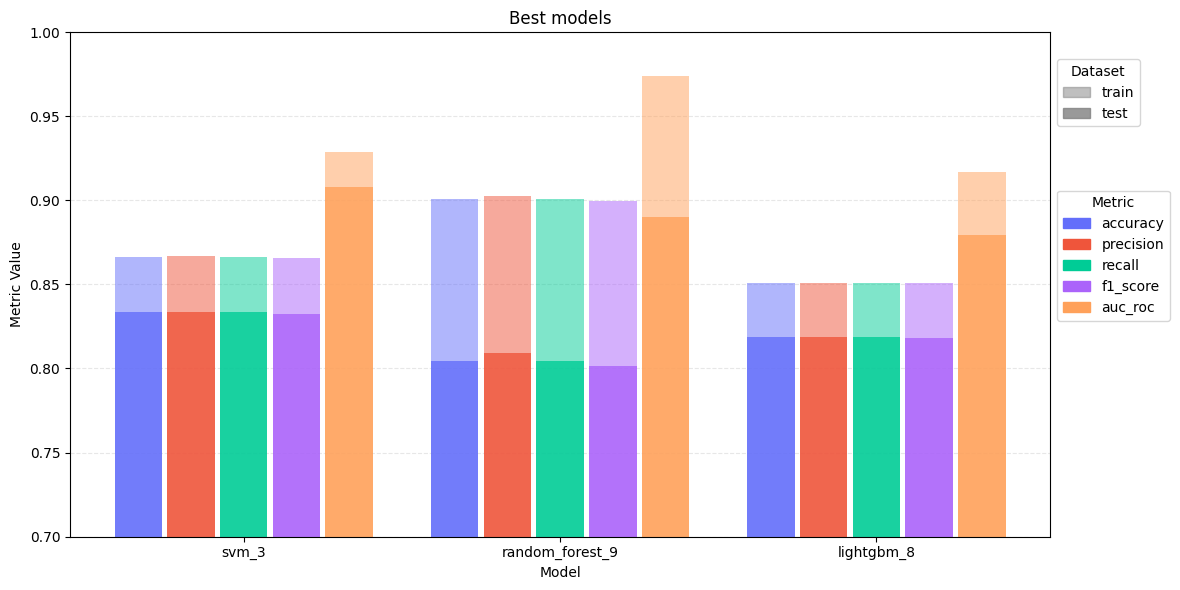

In [4]:
def plot_metric_bars_by_model(df_svm, df_rf, df_lgbm, models = ['svm_1', 'random_forest_1', 'lightgbm_1'], title="Default models"):
    """
    Tworzy wykres słupkowy porównujący metryki (train/test) dla modeli: SVM, RF, LGBM.
    Model jest osią X (zamiast parametru).
    """

    # Dodaj kolumnę z nazwą modelu
    df_svm = df_svm.copy()
    df_rf = df_rf.copy()
    df_lgbm = df_lgbm.copy()

    df_svm["model_name"] = models[0]
    df_rf["model_name"] = models[1]
    df_lgbm["model_name"] = models[2]

    df_all = pd.concat([df_svm, df_rf, df_lgbm], ignore_index=True)

    # Metryki i kolory
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    colors = {
        'accuracy': '#636EFA',
        'precision': '#EF553B',
        'recall': '#00CC96',
        'f1_score': '#AB63FA',
        'auc_roc': '#FFA15A'
    }

    # Przygotuj dane
    melted_data = []
    for _, row in df_all.iterrows():
        model = row['model_name']
        for metric in metrics:
            for ds in ['train', 'test']:
                key = f'{ds}_{metric}'
                if key in row and pd.notna(row[key]):
                    melted_data.append({
                        'model': model,
                        'metric': metric,
                        'dataset': ds,
                        'value': row[key]
                    })

    df_plot = pd.DataFrame(melted_data)

    unique_models = df_plot['model'].unique()
    n_metrics = len(metrics)
    bar_width = 0.9
    spacing = 1.0

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, model in enumerate(unique_models):
        for j, metric in enumerate(metrics):
            base_x = i * (n_metrics + spacing)
            x = base_x + j
            df_subset = df_plot[(df_plot['model'] == model) & (df_plot['metric'] == metric)]

            for ds in ['train', 'test']:
                val = df_subset[df_subset['dataset'] == ds]['value'].values
                if val.size > 0:
                    alpha = 0.5 if ds == 'train' else 0.8
                    ax.bar(x, val[0], color=colors[metric], alpha=alpha, width=bar_width)

    # Oś X
    ax.set_xticks([(i * (n_metrics + spacing)) + (n_metrics - 1) / 2 for i in range(len(unique_models))])
    ax.set_xticklabels(unique_models)
    ax.set_xlabel("Model")
    ax.set_ylabel("Metric Value")
    ax.set_title(title)
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.set_ylim(0.7, 1.0)

    # Legenda metryk (kolory)
    metric_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[m], alpha=1.0) for m in metrics]
    metric_labels = metrics

    # Legenda przezroczystości: train/test
    transparency_handles = [
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.5),
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.8)
    ]
    transparency_labels = ["train", "test"]

    legend2 = ax.legend(transparency_handles, transparency_labels, title="Dataset", loc='lower left', bbox_to_anchor=(1, 0.80))
    legend1 = ax.legend(metric_handles, metric_labels, title="Metric", loc='upper left', bbox_to_anchor=(1, 0.7))
    ax.add_artist(legend2)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

plot_metric_bars_by_model(df_svm, df_rf, df_lgbm)

plot_metric_bars_by_model(df_svm, df_rf, df_lgbm, models=['svm_3', 'random_forest_9', 'lightgbm_8'], title="Best models")


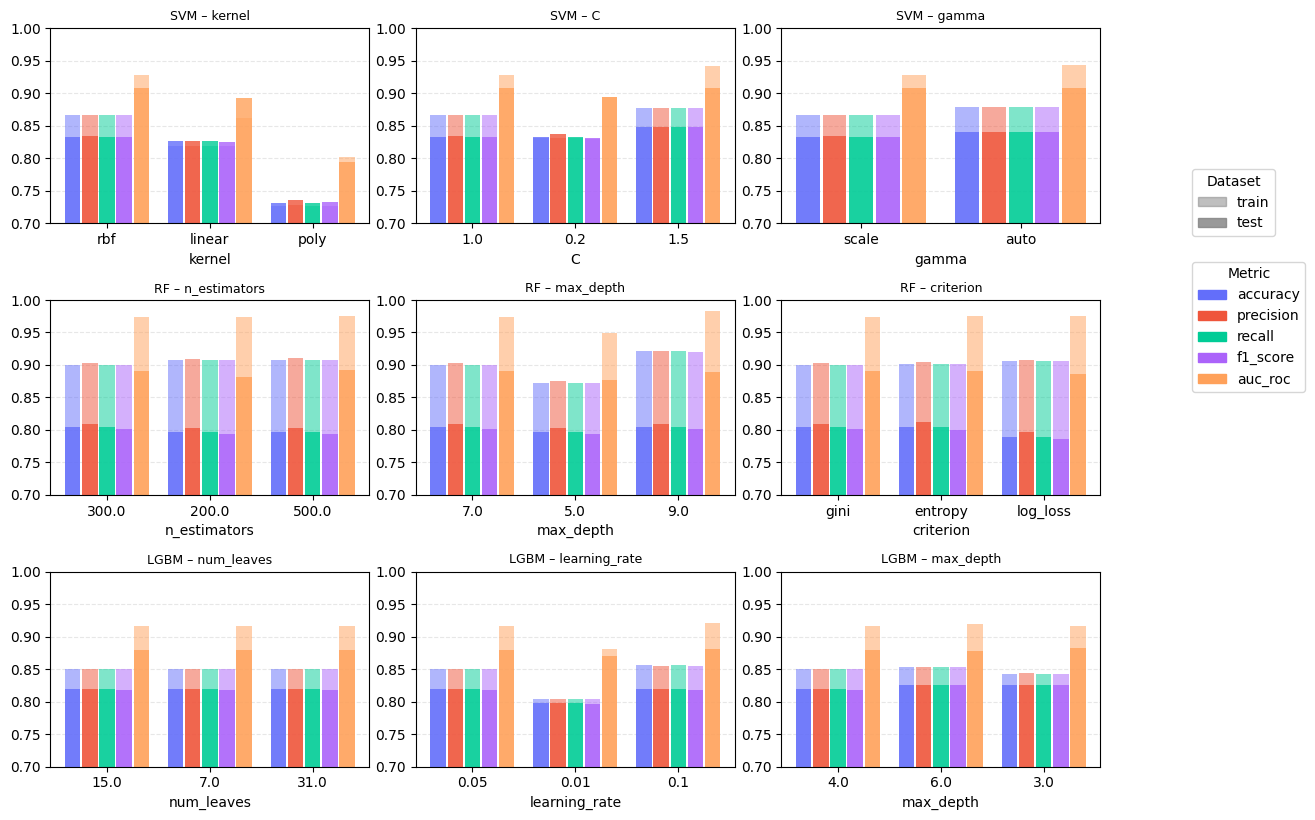

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_metric_bars_grid(
    dfs: list[pd.DataFrame],
    params: list[str],
    prefixes: list[str],
    titles: list[str]
):
    """
    Rysuje 9 wykresów (3x3) typu 'plot_metric_bars_by_param' na jednym płótnie.
    """
    assert len(dfs) == len(params) == len(prefixes) == len(titles) == 9

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    colors = {
        'accuracy': '#636EFA',
        'precision': '#EF553B',
        'recall': '#00CC96',
        'f1_score': '#AB63FA',
        'auc_roc': '#FFA15A'
    }

    fig, axes = plt.subplots(3, 3, figsize=(11.7, 8.3))  # A4 landscape in inches

    for idx, (df, param, prefix, title) in enumerate(zip(dfs, params, prefixes, titles)):
        row, col = divmod(idx, 3)
        ax = axes[row, col]

        # Param column
        if prefix in ["svm", "rf", "random_forest"]:
            param_col = f"static_{param}"
        elif prefix in ["lgbm", "lightgbm"]:
            param_col = f"final_{param}"
        else:
            continue

        if param_col not in df.columns:
            continue

        df_param = df.dropna(subset=[param_col])
        if df_param.empty:
            continue

        # Prepare melted data
        melted_data = []
        for _, row_data in df_param.iterrows():
            param_val = row_data[param_col]
            for metric in metrics:
                for ds in ['train', 'test']:
                    melted_data.append({
                        'param': str(param_val),
                        'metric': metric,
                        'value': row_data[f'{ds}_{metric}'],
                        'dataset': ds
                    })

        df_plot = pd.DataFrame(melted_data)
        unique_params = df_plot['param'].unique()
        n_metrics = len(metrics)
        bar_width = 0.9
        spacing = 1.0

        for i, p in enumerate(unique_params):
            for j, metric in enumerate(metrics):
                base_x = i * (n_metrics + spacing)
                x = base_x + j
                df_subset = df_plot[(df_plot['param'] == p) & (df_plot['metric'] == metric)]
                for ds in ['train', 'test']:
                    val = df_subset[df_subset['dataset'] == ds]['value'].values
                    if val.size > 0:
                        alpha = 0.5 if ds == 'train' else 0.8
                        ax.bar(x, val[0], color=colors[metric], alpha=alpha, width=bar_width)

        ax.set_xticks([(i * (n_metrics + spacing)) + (n_metrics - 1) / 2 for i in range(len(unique_params))])
        ax.set_xticklabels(unique_params)
        ax.set_xlabel(param)
        ax.set_ylim(0.7, 1.0)
        ax.set_title(title, fontsize=9)
        ax.yaxis.grid(True, linestyle='--', alpha=0.3)
        ax.set_axisbelow(True)

    # Wspólna legenda poza siatką
    metric_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[m], alpha=1.0) for m in metrics]
    transparency_handles = [
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.5),
        plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.8)
    ]
    fig.legend(metric_handles, metrics, title="Metric", loc='center left', bbox_to_anchor=(1.01, 0.6))
    fig.legend(transparency_handles, ["train", "test"], title="Dataset", loc='center left', bbox_to_anchor=(1.01, 0.75))

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()


plot_metric_bars_grid(
    dfs=[df_svm, df_svm, df_svm, df_rf, df_rf, df_rf, df_lgbm, df_lgbm, df_lgbm],
    params=["kernel", "C", "gamma", "n_estimators", "max_depth", "criterion", "num_leaves", "learning_rate", "max_depth"],
    prefixes=["svm"]*3 + ["rf"]*3 + ["lgbm"]*3,
    titles=[
        "SVM – kernel", "SVM – C", "SVM – gamma",
        "RF – n_estimators", "RF – max_depth", "RF – criterion",
        "LGBM – num_leaves", "LGBM – learning_rate", "LGBM – max_depth"
    ]
)


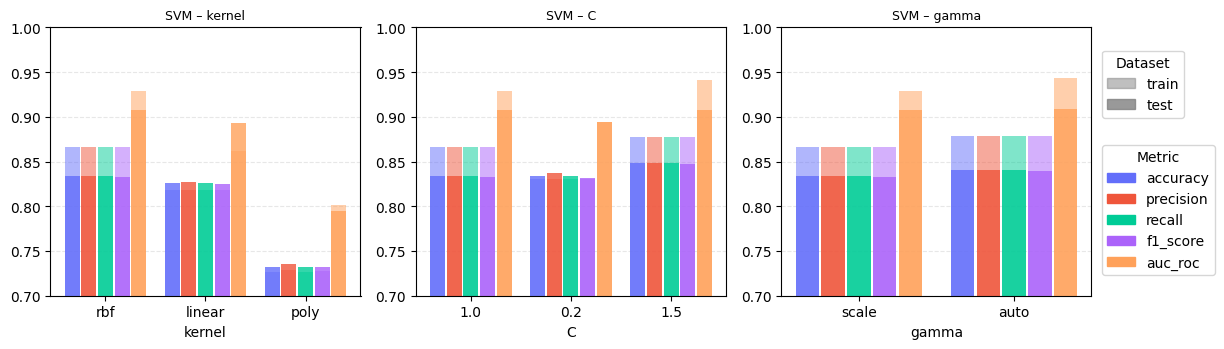

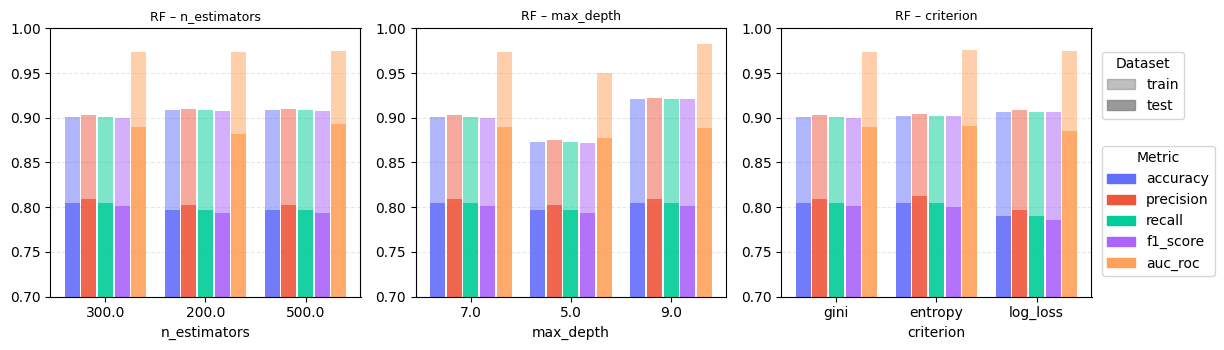

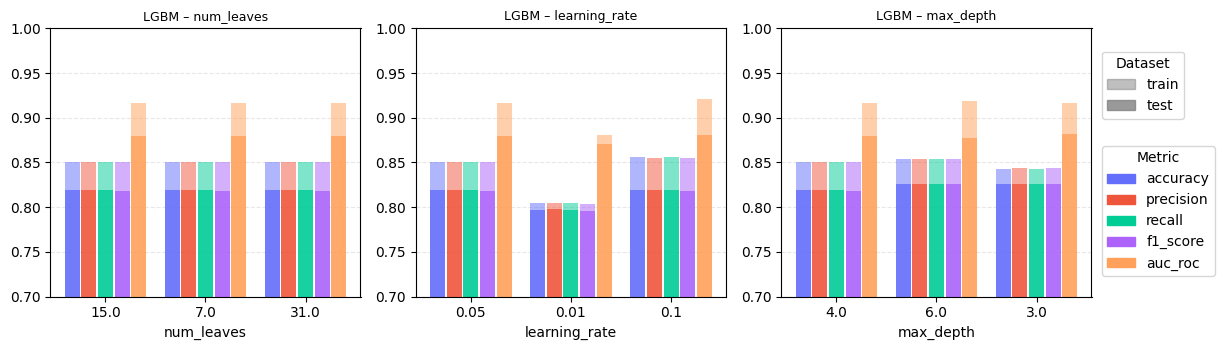

In [6]:
def plot_metric_bars_separate_figures(
    dfs: list[pd.DataFrame],
    params: list[str],
    prefixes: list[str],
    titles: list[str]
):
    """
    Tworzy 3 oddzielne figury, każda z 3 subplotami dla danego modelu.
    """
    assert len(dfs) == len(params) == len(prefixes) == len(titles) == 9

    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    colors = {
        'accuracy': '#636EFA',
        'precision': '#EF553B',
        'recall': '#00CC96',
        'f1_score': '#AB63FA',
        'auc_roc': '#FFA15A'
    }

    for fig_num in range(3):
        fig, axes = plt.subplots(1, 3, figsize=(11.7, 3.6))  # 3 subploty w jednej figurze

        for i in range(3):
            idx = fig_num * 3 + i
            df = dfs[idx]
            param = params[idx]
            prefix = prefixes[idx]
            title = titles[idx]
            ax = axes[i]

            if prefix in ["svm", "rf", "random_forest"]:
                param_col = f"static_{param}"
            elif prefix in ["lgbm", "lightgbm"]:
                param_col = f"final_{param}"
            else:
                continue

            if param_col not in df.columns:
                continue

            df_param = df.dropna(subset=[param_col])
            if df_param.empty:
                continue

            melted_data = []
            for _, row_data in df_param.iterrows():
                param_val = row_data[param_col]
                for metric in metrics:
                    for ds in ['train', 'test']:
                        melted_data.append({
                            'param': str(param_val),
                            'metric': metric,
                            'value': row_data[f'{ds}_{metric}'],
                            'dataset': ds
                        })

            df_plot = pd.DataFrame(melted_data)
            unique_params = df_plot['param'].unique()
            n_metrics = len(metrics)
            bar_width = 0.9
            spacing = 1.0

            for j, p in enumerate(unique_params):
                for k, metric in enumerate(metrics):
                    base_x = j * (n_metrics + spacing)
                    x = base_x + k
                    df_subset = df_plot[(df_plot['param'] == p) & (df_plot['metric'] == metric)]
                    for ds in ['train', 'test']:
                        val = df_subset[df_subset['dataset'] == ds]['value'].values
                        if val.size > 0:
                            alpha = 0.5 if ds == 'train' else 0.8
                            ax.bar(x, val[0], color=colors[metric], alpha=alpha, width=bar_width)

            ax.set_xticks([(j * (n_metrics + spacing)) + (n_metrics - 1) / 2 for j in range(len(unique_params))])
            ax.set_xticklabels(unique_params)
            ax.set_xlabel(param)
            ax.set_ylim(0.7, 1.0)
            ax.set_title(title, fontsize=9)
            ax.yaxis.grid(True, linestyle='--', alpha=0.3)
            ax.set_axisbelow(True)

        metric_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[m], alpha=1.0) for m in metrics]
        transparency_handles = [
            plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.5),
            plt.Rectangle((0, 0), 1, 1, color='gray', alpha=0.8)
        ]
        fig.legend(metric_handles, metrics, title="Metric", loc='center left', bbox_to_anchor=(0.94, 0.4))
        fig.legend(transparency_handles, ["train", "test"], title="Dataset", loc='center left', bbox_to_anchor=(0.94, 0.75))

        plt.tight_layout(rect=[0, 0, 0.95, 1])
        plt.show()


plot_metric_bars_separate_figures(
    dfs=[
        df_svm, df_svm, df_svm,
        df_rf, df_rf, df_rf,
        df_lgbm, df_lgbm, df_lgbm
    ],
    params=[
        "kernel", "C", "gamma",
        "n_estimators", "max_depth", "criterion",
        "num_leaves", "learning_rate", "max_depth"
    ],
    prefixes=[
        "svm", "svm", "svm",
        "rf", "rf", "rf",
        "lgbm", "lgbm", "lgbm"
    ],
    titles=[
        "SVM – kernel", "SVM – C", "SVM – gamma",
        "RF – n_estimators", "RF – max_depth", "RF – criterion",
        "LGBM – num_leaves", "LGBM – learning_rate", "LGBM – max_depth"
    ]
)


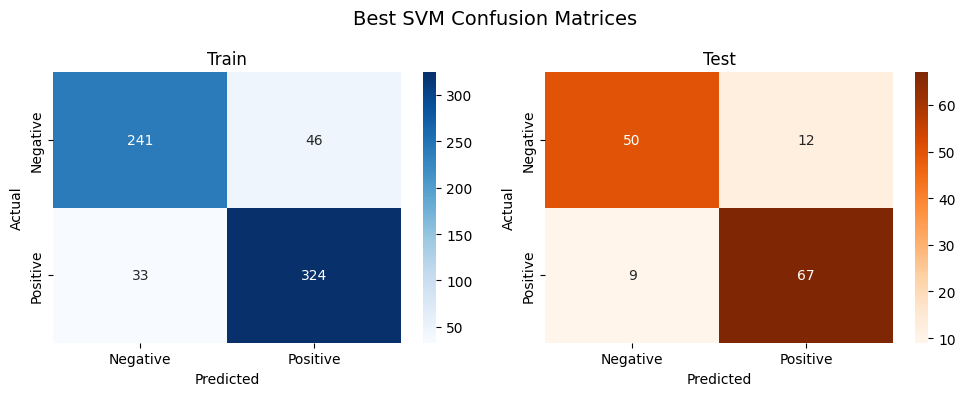

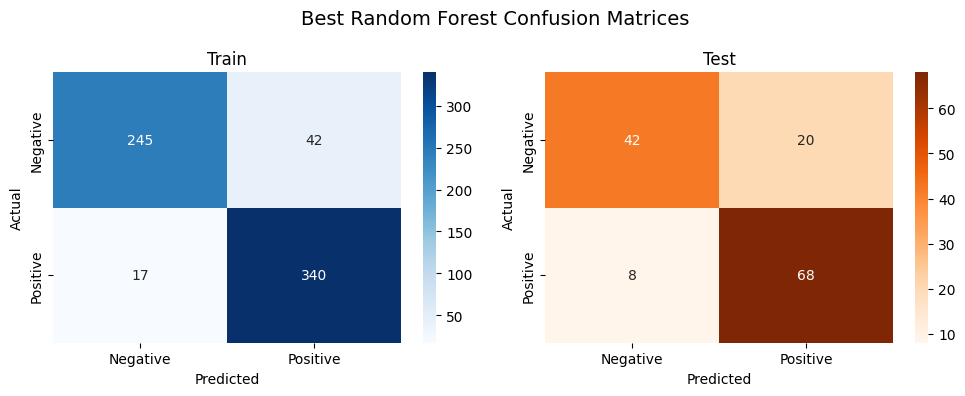

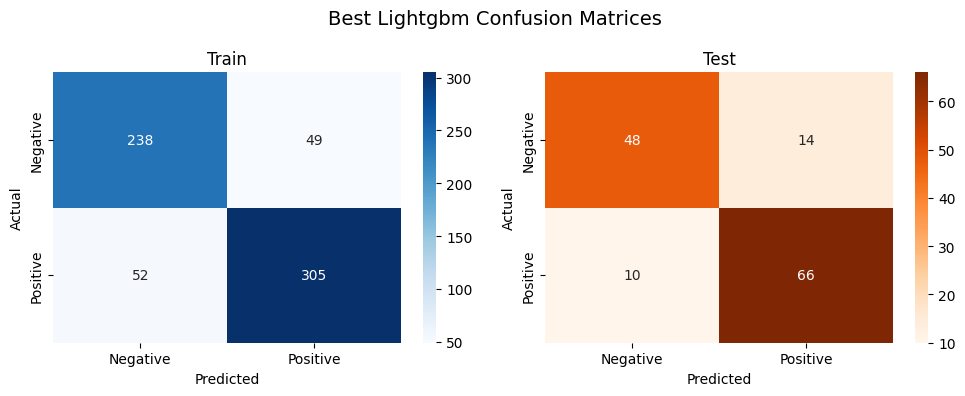

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_conf_matrices_from_binary_metrics(df: pd.DataFrame, model_name: str, title: str = "Confusion Matrices"):
    """
    Tworzy 2 macierze pomyłek (train/test) z danych: *_tp, *_tn, *_fp, *_fn.
    """
    row = df[df['Unnamed: 0'] == model_name]
    if row.empty:
        print(f"⚠️ Brak danych dla modelu: {model_name}")
        return

    def build_matrix(prefix):
        tp = row[f'{prefix}_tp'].values[0]
        tn = row[f'{prefix}_tn'].values[0]
        fp = row[f'{prefix}_fp'].values[0]
        fn = row[f'{prefix}_fn'].values[0]
        return np.array([[tn, fp],
                         [fn, tp]])

    cm_train = build_matrix('train')
    cm_test = build_matrix('test')

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=axes[1])

    axes[0].set_title("Train")
    axes[1].set_title("Test")
    for ax in axes:
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_xticks([0.5, 1.5])
        ax.set_yticks([0.5, 1.5])
        ax.set_xticklabels(['Negative', 'Positive'])
        ax.set_yticklabels(['Negative', 'Positive'])

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


plot_conf_matrices_from_binary_metrics(df_svm, model_name="svm_3", title="Best SVM Confusion Matrices")
plot_conf_matrices_from_binary_metrics(df_rf, model_name="random_forest_9", title="Best Random Forest Confusion Matrices")
plot_conf_matrices_from_binary_metrics(df_lgbm, model_name="lightgbm_8", title="Best Lightgbm Confusion Matrices")


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_train_test_diff_metrics_heatmaps(df: pd.DataFrame, model_prefix: str):
    """
    Tworzy wykres z trzema heatmapami: metryki train, test oraz różnice (test - train)
    dla modeli typu prefix. Osie X: metryki, Y: modele.
    Każda heatmapa ma niezależną skalę kolorów.
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    train_cols = [f"train_{m}" for m in metrics]
    test_cols = [f"test_{m}" for m in metrics]

    df_models = df[df["Unnamed: 0"].str.startswith(model_prefix)].copy()
    df_models = df_models[["Unnamed: 0"] + train_cols + test_cols]
    df_models.set_index("Unnamed: 0", inplace=True)

    df_train = df_models[train_cols].copy()
    df_train.columns = metrics

    df_test = df_models[test_cols].copy()
    df_test.columns = metrics

    df_diff = df_test - df_train

    fig, axes = plt.subplots(1, 3, figsize=(25, 0.6 * len(df_train)))

    sns.heatmap(df_train, annot=True, fmt=".3f", cmap="magma", linewidths=0.5,
                cbar=True, ax=axes[0])
    axes[0].set_title(f"{model_prefix.upper()} – Train metrics")
    axes[0].set_xlabel("Metric")
    axes[0].set_ylabel("Model")

    sns.heatmap(df_test, annot=True, fmt=".3f", cmap="magma", linewidths=0.5,
                cbar=True, ax=axes[1])
    axes[1].set_title(f"{model_prefix.upper()} – Test metrics")
    axes[1].set_xlabel("Metric")
    axes[1].set_ylabel("")

    sns.heatmap(df_diff, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.5,
                cbar=True, ax=axes[2])
    axes[2].set_title(f"{model_prefix.upper()} – Test - Train diff")
    axes[2].set_xlabel("Metric")
    axes[2].set_ylabel("")

    plt.tight_layout()
    plt.show()


def plot_train_test_diff_metrics_heatmaps_all_metrics(df: pd.DataFrame, model_prefix: str):
    """
    Tworzy wykres z trzema heatmapami: metryki train, test oraz różnice (test - train)
    dla modeli typu prefix. Osie X: metryki, Y: modele.
    Każda heatmapa ma niezależną skalę kolorów.
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
    train_cols = [f"train_{m}" for m in metrics]
    test_cols = [f"test_{m}" for m in metrics]

    df_models = df[df["Unnamed: 0"].str.startswith(model_prefix)].copy()
    df_models = df_models[["Unnamed: 0"] + train_cols + test_cols]
    df_models.set_index("Unnamed: 0", inplace=True)

    df_train = df_models[train_cols].copy()
    df_train.columns = metrics

    df_test = df_models[test_cols].copy()
    df_test.columns = metrics

    df_diff = df_test - df_train

    fig, axes = plt.subplots(1, 3, figsize=(25, 0.6 * len(df_train)))

    sns.heatmap(df_train, annot=True, fmt=".3f", cmap="magma", linewidths=0.5,
                cbar=True, ax=axes[0])
    axes[0].set_title(f"{model_prefix.upper()} – Train metrics")
    axes[0].set_xlabel("Metric")
    axes[0].set_ylabel("Model")

    sns.heatmap(df_test, annot=True, fmt=".3f", cmap="magma", linewidths=0.5,
                cbar=True, ax=axes[1])
    axes[1].set_title(f"{model_prefix.upper()} – Test metrics")
    axes[1].set_xlabel("Metric")
    axes[1].set_ylabel("")

    sns.heatmap(df_diff, annot=True, fmt=".3f", cmap="coolwarm", center=0, linewidths=0.5,
                cbar=True, ax=axes[2])
    axes[2].set_title(f"{model_prefix.upper()} – Test - Train diff")
    axes[2].set_xlabel("Metric")
    axes[2].set_ylabel("")

    plt.tight_layout()
    plt.show()





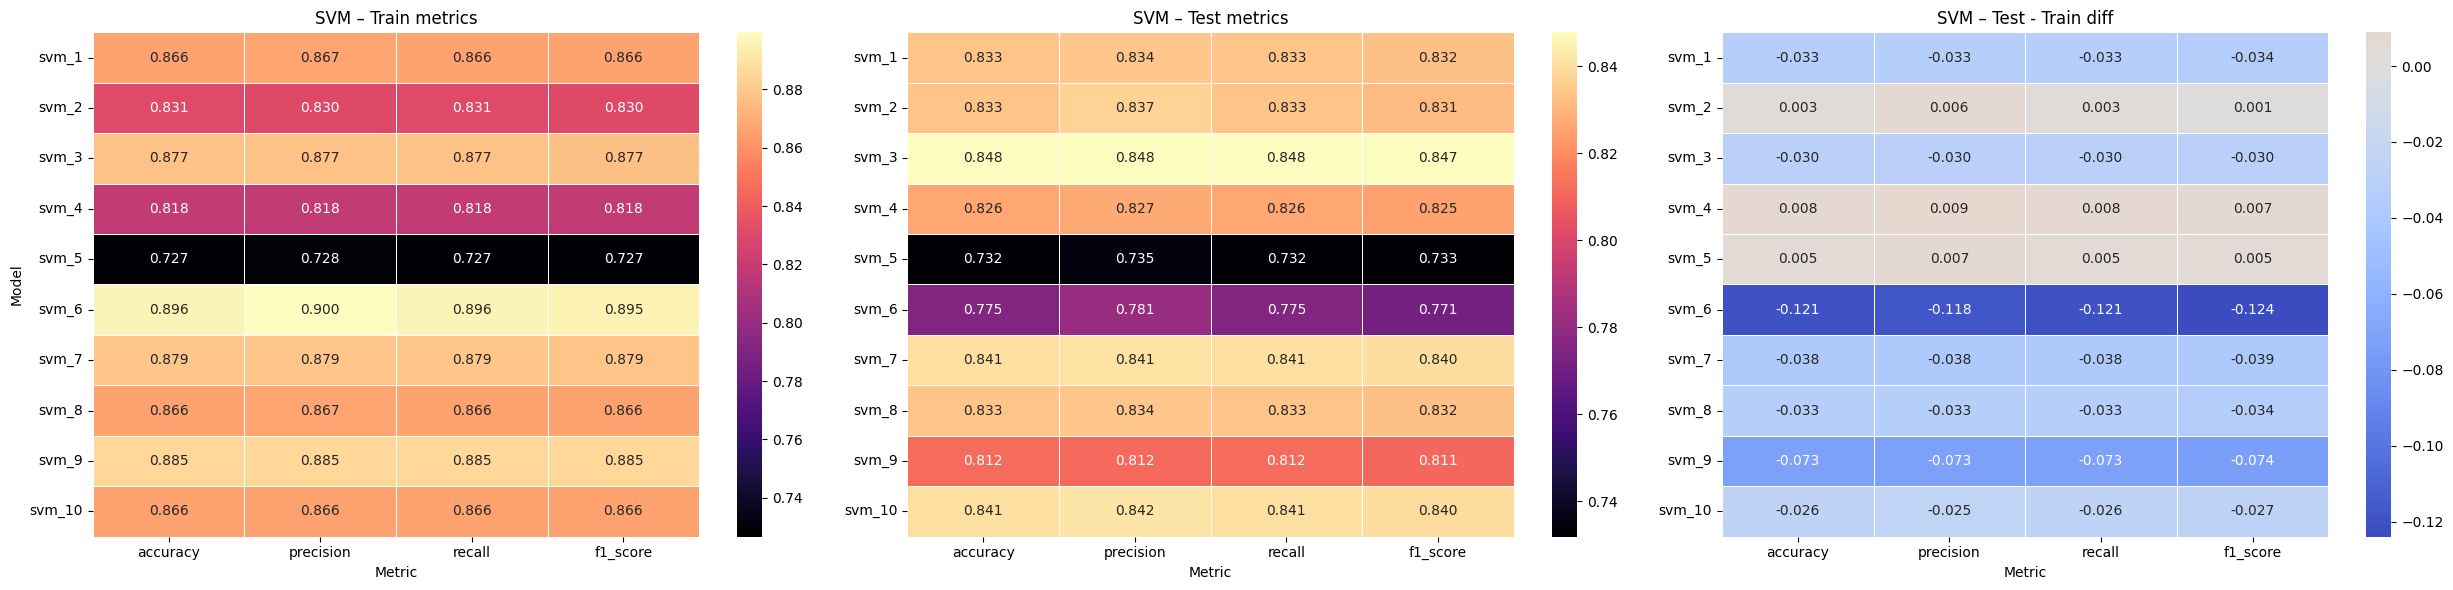

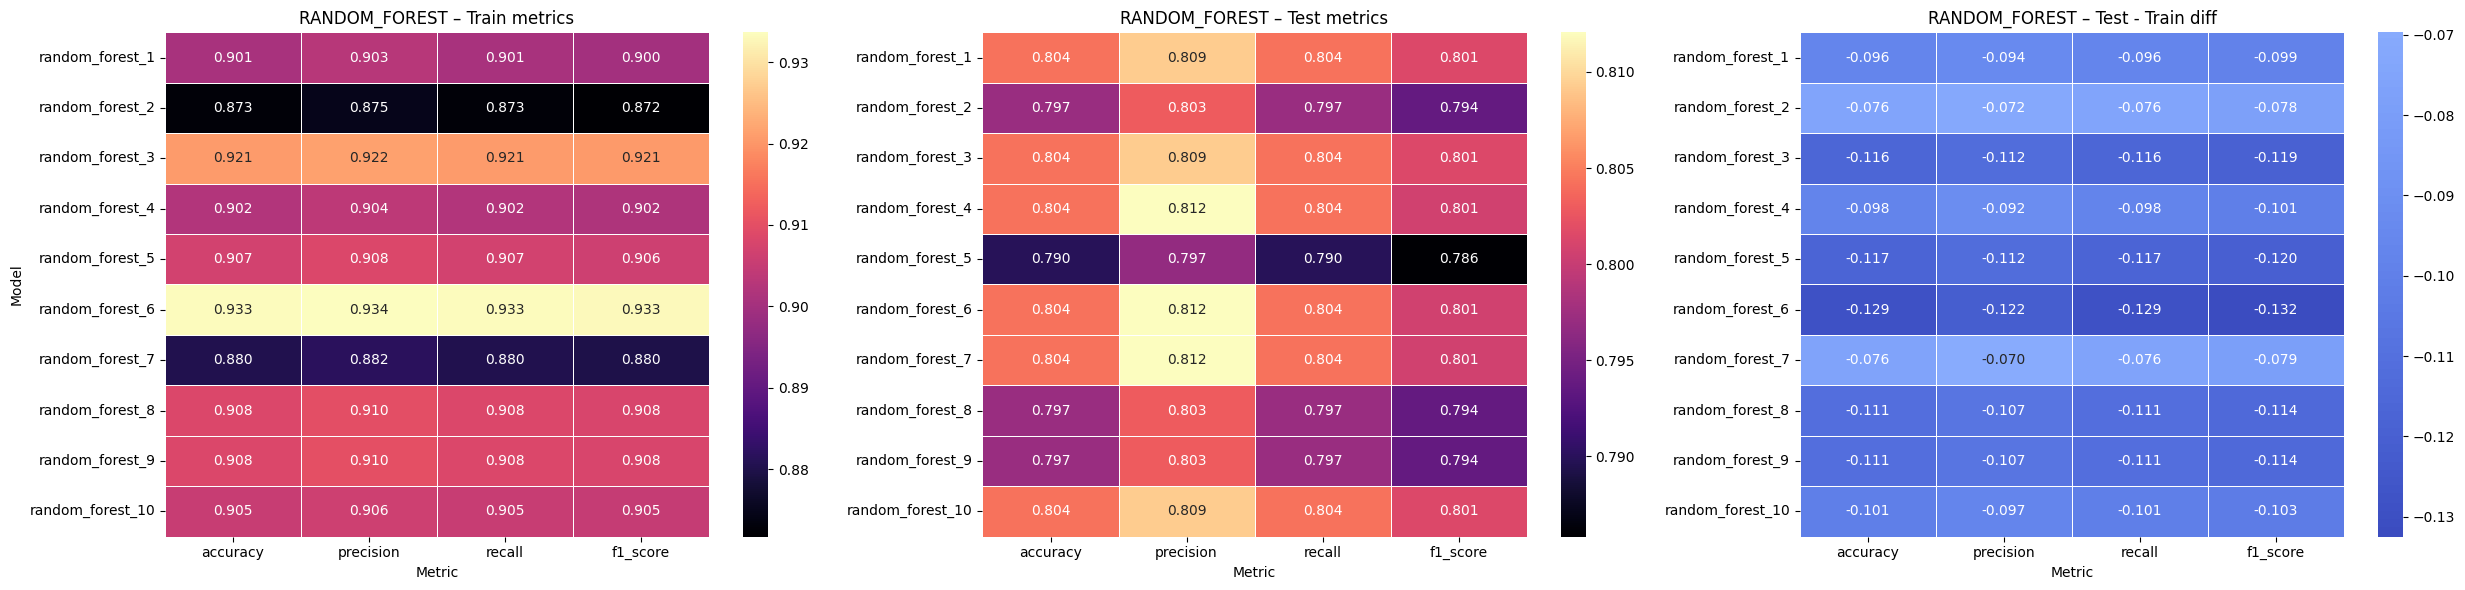

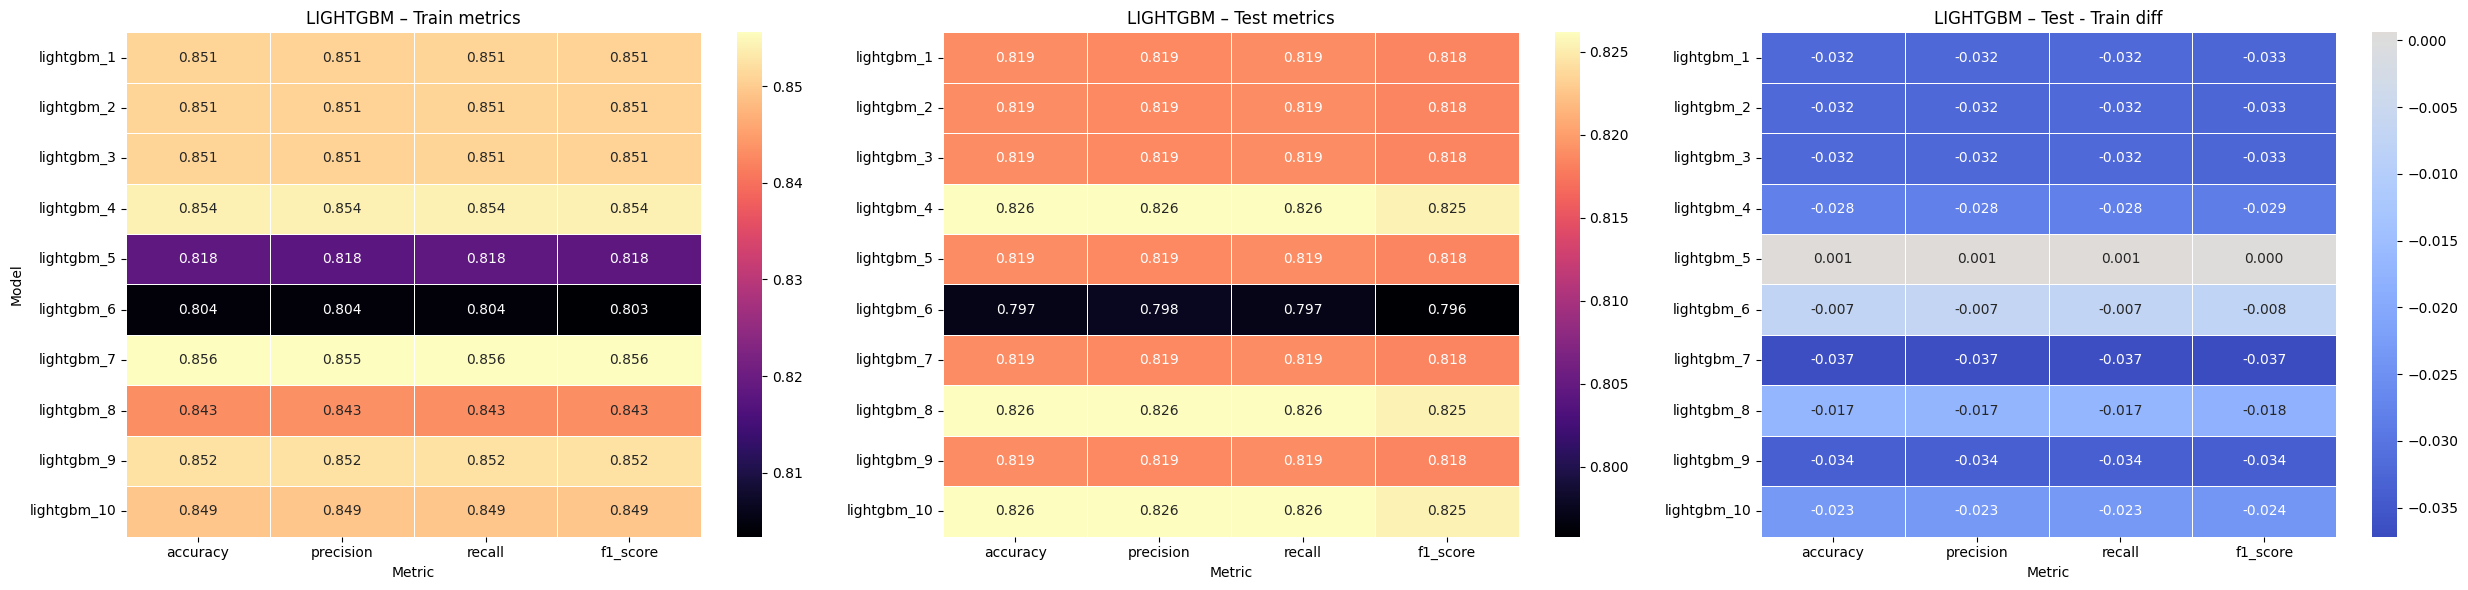

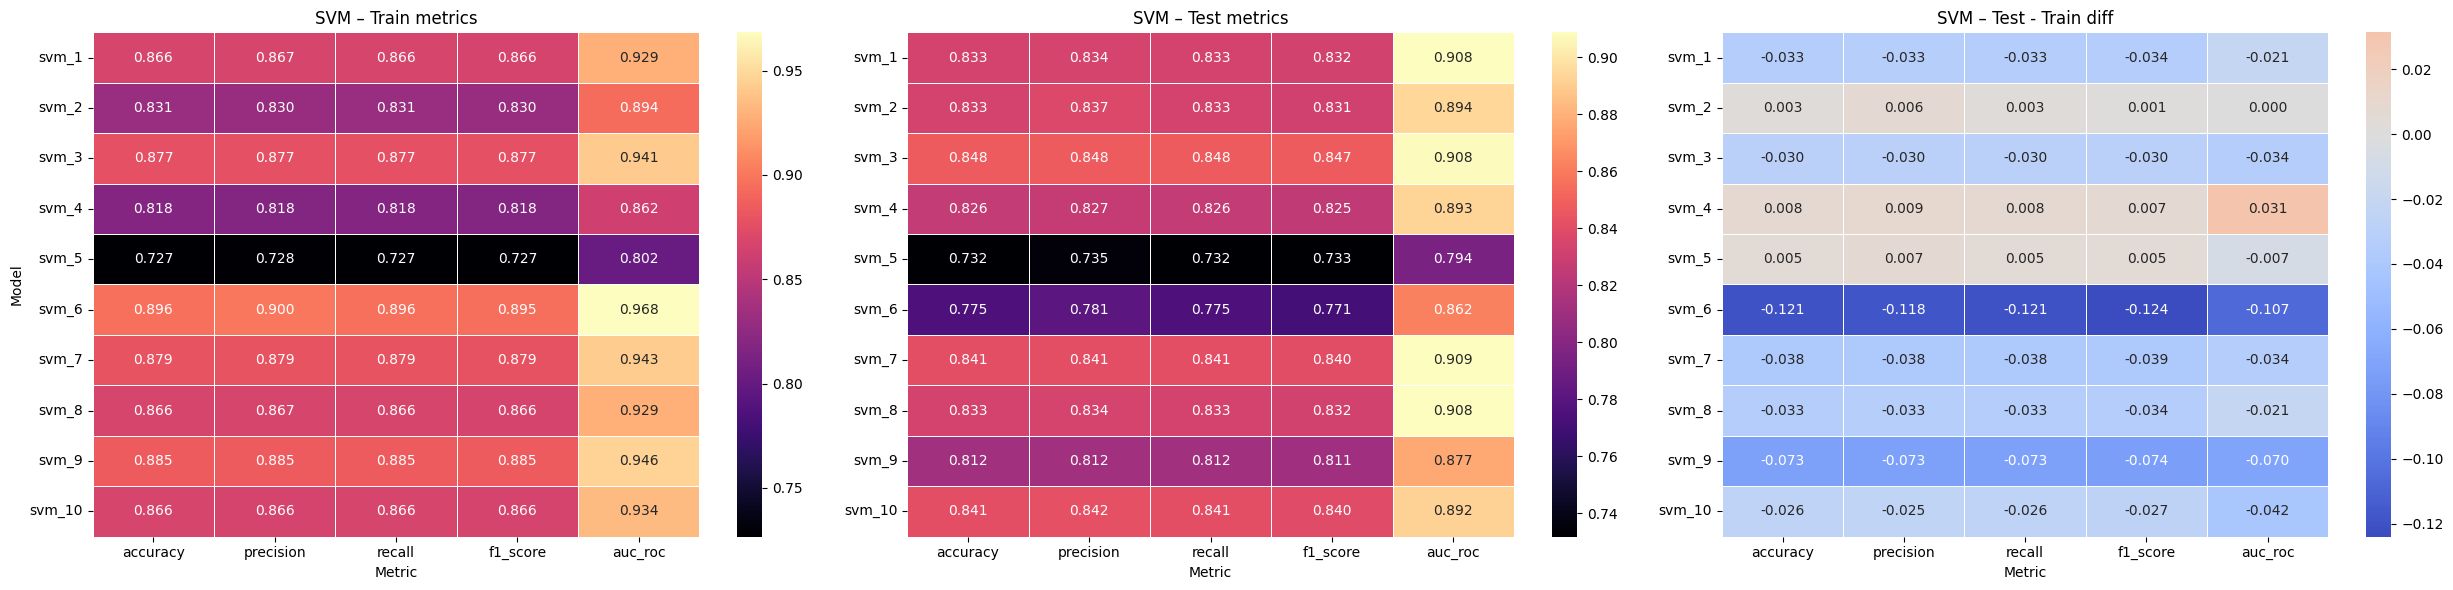

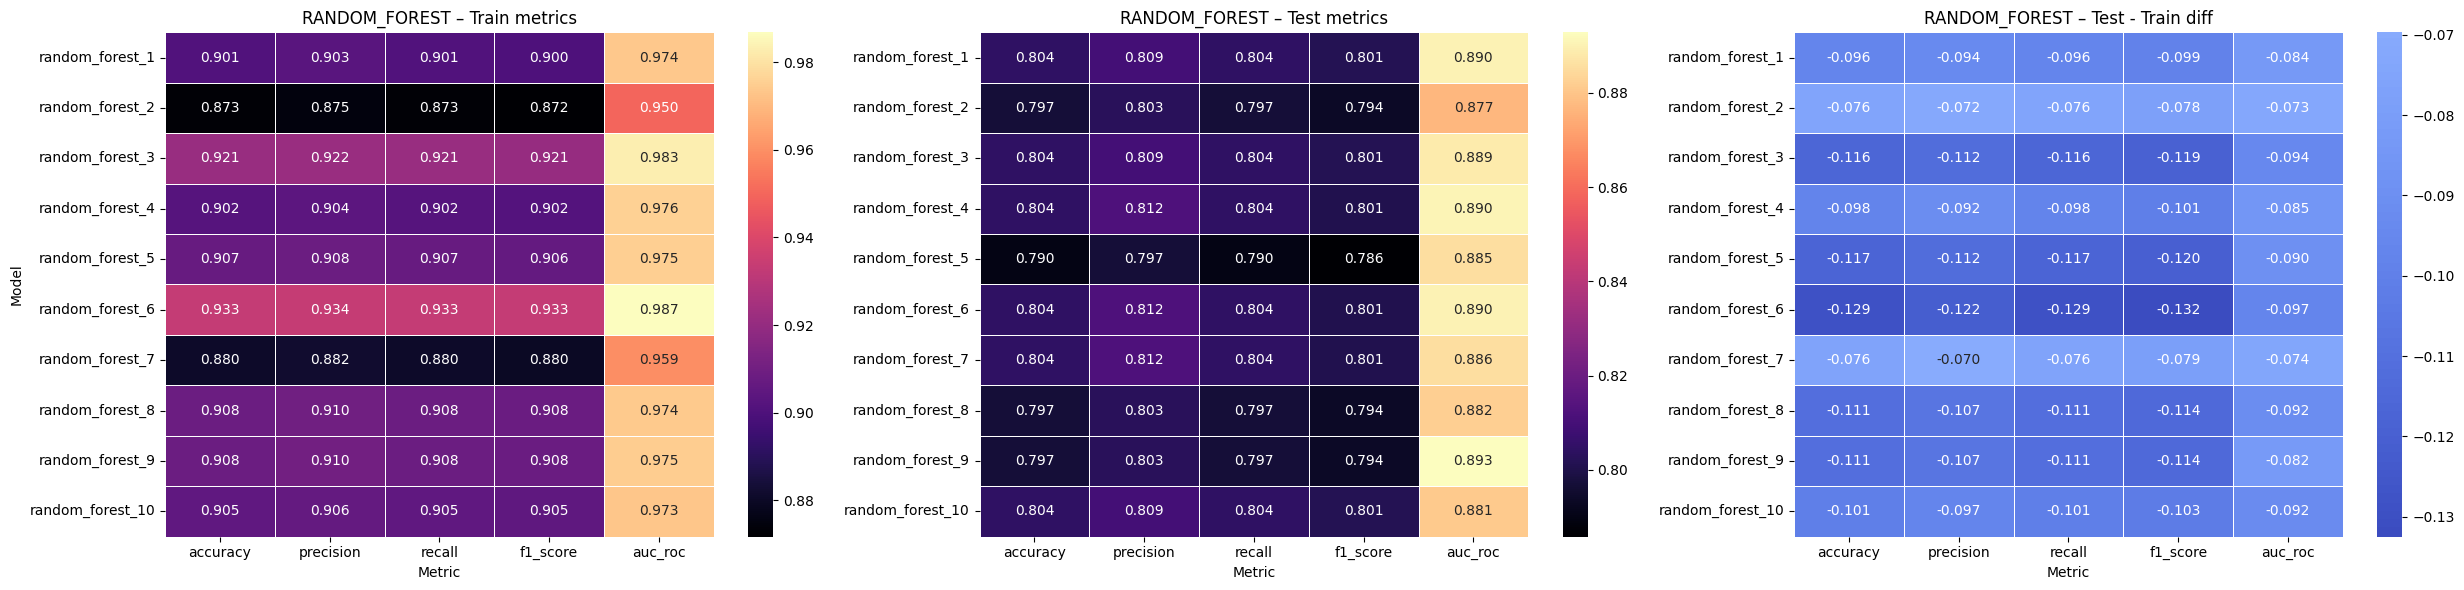

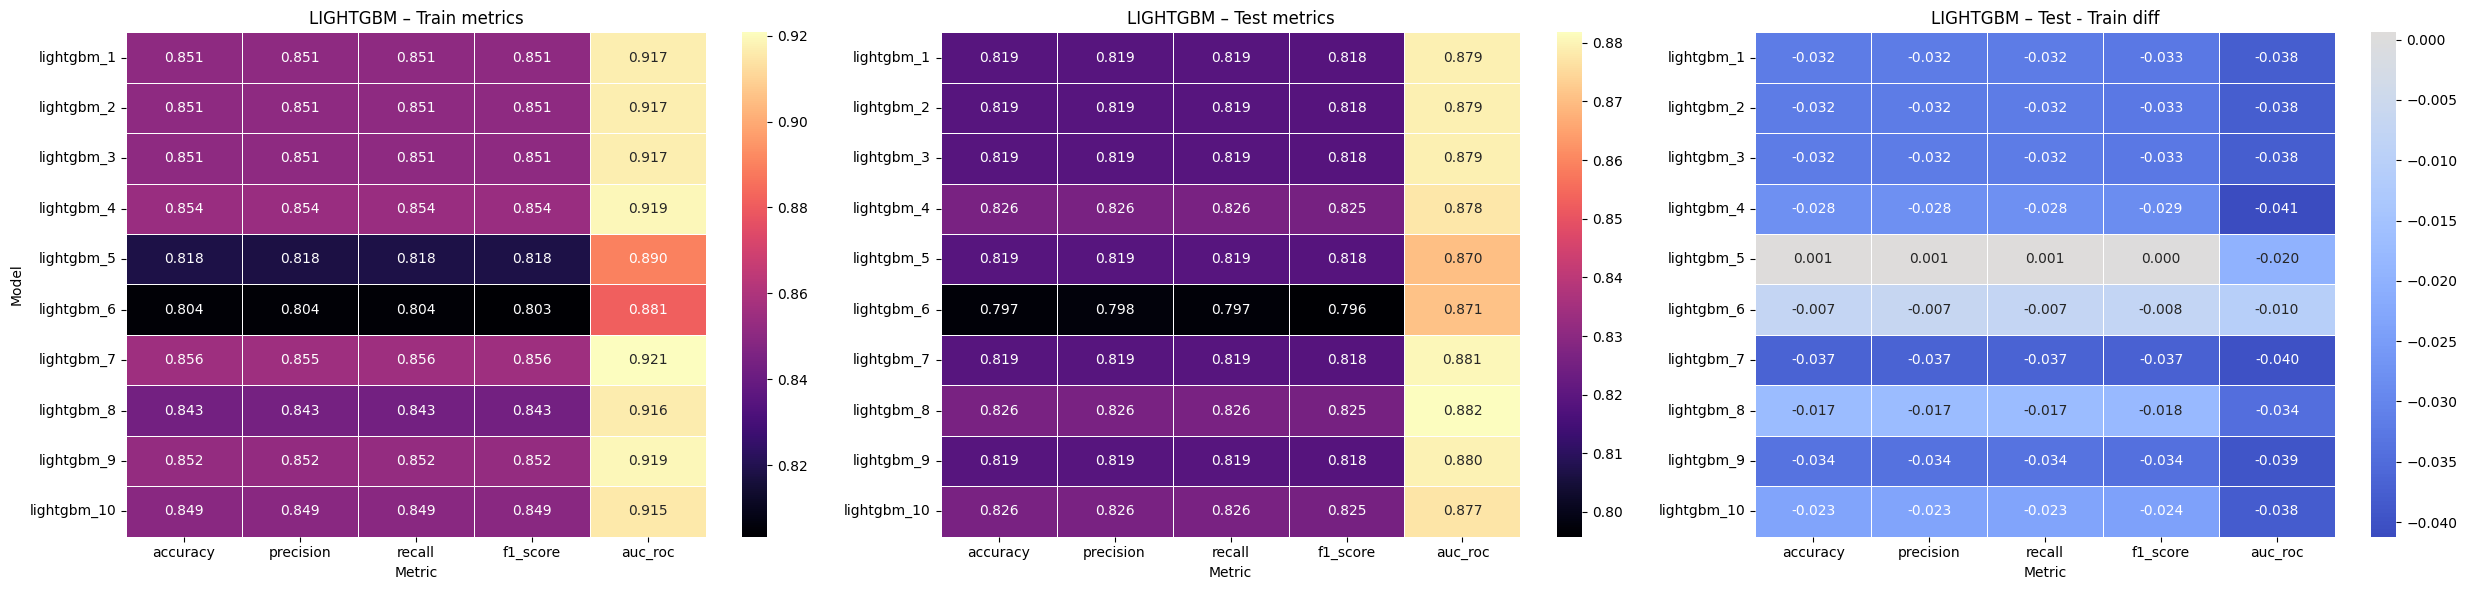

In [9]:

plot_train_test_diff_metrics_heatmaps(df_raw, model_prefix="svm")
plot_train_test_diff_metrics_heatmaps(df_raw, model_prefix="random_forest")
plot_train_test_diff_metrics_heatmaps(df_raw, model_prefix="lightgbm")

plot_train_test_diff_metrics_heatmaps_all_metrics(df_raw, model_prefix="svm")
plot_train_test_diff_metrics_heatmaps_all_metrics(df_raw, model_prefix="random_forest")
plot_train_test_diff_metrics_heatmaps_all_metrics(df_raw, model_prefix="lightgbm")
